<a href="https://colab.research.google.com/github/Harrow-Enigma/TeamEngima-ProjectEco-AI/blob/main/Project_Eco_AI_Beta_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project ECO AI Beta Testing Model

Copyright 2021 YIDING SONG

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!pip install tabulate
!curl -o label_classes.py https://raw.githubusercontent.com/Harrow-Enigma/TeamEngima-ProjectEco-AI/main/label_classes.py

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import timedelta, timezone
from datetime import datetime as dt
from tqdm import tqdm
import pickle as pkl
import requests
import json
import os

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.titlecolor'] = 'green'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'

In [ ]:
np.random.seed(219)
tf.random.set_seed(219)

## Loading the data

In [ ]:
def str2date(s):
  return dt.strptime(s, '%Y-%m-%dT%H:%M:%S.%f%z')

def dict2date(data_dict):
  return str2date(data_dict['DATE'])

In [ ]:
beta_api_url = 'https://dev-test.projecteco.ml/api/v1/rest/output/forms/'
response = requests.get(beta_api_url)
json_data = response.json()
json_data = sorted(json_data, key = dict2date)

In [ ]:
for k in range(len(json_data)):
  try:
    _ = json_data[k]['localpollutiondata']
    _has_key = True
  except:
    print('Error: No `localpollutiondata` key')
    _has_key = False
  
  if _has_key:
    for pol_key in list(json_data[k]['localpollutiondata']\
                        ['data'].keys()):
      json_data[k][pol_key] = json_data[k]['localpollutiondata']\
                                       ['data'][pol_key]['v']
    json_data[k].pop('localpollutiondata')

In [ ]:
print(json.dumps(json_data, indent=4, sort_keys=True))

[
    {
        "DATE": "2021-08-02T09:55:03.296Z",
        "__v": 0,
        "_id": "6107c0f71582990028230432",
        "co": 6.3,
        "h": 77.5,
        "no2": 34.3,
        "o3": 15.8,
        "p": 997.1,
        "pm10": 35,
        "pm25": 79,
        "q1": 2,
        "q2": 4,
        "q3": 4,
        "q4": "no",
        "q5": "no",
        "so2": 2.5,
        "t": 31.6,
        "uvi": 1,
        "w": 1.5,
        "wg": 6
    },
    {
        "DATE": "2021-08-02T10:14:29.689Z",
        "__v": 0,
        "_id": "6107c5851582990028230434",
        "dew": 12,
        "h": 87,
        "no2": 22,
        "o3": 2,
        "p": 1015,
        "pm10": 10,
        "pm25": 13,
        "q1": 4,
        "q2": 3,
        "q3": 4,
        "q4": "no",
        "q5": "no",
        "t": 14,
        "w": 1.5,
        "wg": 17.4
    },
    {
        "DATE": "2021-08-02T22:13:06.335Z",
        "__v": 0,
        "_id": "61086df215a71b002169c013",
        "h": 75,
        "no2": 7.8,
        "o3": 25.

## Defining the labels

In [ ]:
FEATURE_CLASSES = [
  FloatLabel('h'), FloatLabel('no2'), FloatLabel('o3'),
  FloatLabel('p'), FloatLabel('pm10'), FloatLabel('pm25'),
  FloatLabel('t'), FloatLabel('w'), FloatLabel('wg'),
]

In [ ]:
LABEL_CLASSES = [
  IntClass('Q1 (General feeling)', _key='q1'),
  IntClass('Q2 (Concentration)', _key='q2'),
  IntClass('Q3 (Work Stress)', _key='q3'),
  IntClassMap('Q4 (Dizziness, headaches, shortness of breath)',
              {'no': 0, 'yes': 1},
              _key='q4'),
  IntClassMap('Q5 (Allergic responses)',
              {'no': 0, 'yes': 1},
              _key='q5')
]

## Data Pre-Processing

In [ ]:
def handle_exception(feat_class, timestep_data):
  try:
    _val = timestep_data[feat_class.key]
    if _val is not None:
      return feat_class.fwd_call(_val)
    return feat_class.fallback
  except:
    return feat_class.fallback

In [ ]:
features = []
labels = []

for t in json_data:
  features.append([handle_exception(c, t)
                    for c in FEATURE_CLASSES])
  labels.append([handle_exception(c, t)
                    for c in LABEL_CLASSES])

features = np.array(features, np.float32)
labels = np.array(labels, np.float32)

In [ ]:
def standardize(arr):
  m = arr.mean(0)
  s = arr.std(0)
    
  for i in range(len(s)):
    if s[i] == 0:
      s[i] = 1e-8
  
  arr = (arr - m)/s
  return arr, m, s

def destandardize(arr, m, s):
  return arr * s + m

def rescale(arr, delta=0.01):
  arr_max = arr.max(axis=0) + delta
  arr_min = arr.min(axis=0) - delta
  arr_range = arr_max - arr_min
  arr_ofst = (arr_max + arr_min) / 2
  return (arr - arr_ofst) / arr_range, arr_ofst, arr_range

def descale(arr, arr_ofst, arr_range):
  return arr * arr_range + arr_ofst

def normalize(arr):
  arr_std, m, s = standardize(arr)
  arr_norm, o, r = rescale(arr_std)
  return arr_norm, m, s, o, r

def denormalize(arr, m, s, o, r):
  return destandardize(descale(arr, o, r), m, s)

In [ ]:
(features_norm,
 features_mean,
 features_stddv,
 features_ofst,
 features_range) = normalize(features)

(labels_norm,
 labels_mean,
 labels_stddv,
 labels_ofst,
 labels_range) = normalize(labels)

In [ ]:
assert features.all() == denormalize(features_norm, features_mean,
                                     features_stddv, features_ofst, features_range).all()
assert labels.all() == denormalize(labels_norm, labels_mean,
                                   labels_stddv, labels_ofst, labels_range).all()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

In [ ]:
dataset_size = len(features_norm)
ratio = 9/10
train_no = int(ratio * dataset_size)
test_no = dataset_size - train_no
print('Number of training samples: {}'.format(train_no))
print('Number of testing samples: {}'.format(test_no))

Number of training samples: 17
Number of testing samples: 2


In [ ]:
train_features_norm = features_norm[:train_no]
test_features_norm = features_norm[train_no:]
train_labels_norm = labels_norm[:train_no]
test_labels_norm = labels_norm[train_no:]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_features_norm, train_labels_norm)
).batch(2, drop_remainder=False)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features_norm, test_labels_norm)
).batch(2, drop_remainder=False)

In [ ]:
pkl.dump({
    'features': {
        'classes': FEATURE_CLASSES,
        'mean':    features_mean,
        'std_dev': features_stddv,
        'offset':  features_ofst,
        'range':    features_range
    },
    'labels': {
        'classes': LABEL_CLASSES,
        'mean':    labels_mean,
        'std_dev': labels_stddv,
        'offset':  labels_ofst,
        'range':    labels_range
    },
}, open('beta_data_aux.data', 'wb'))

## Building the model


In [ ]:
class DNNModel(tf.keras.Model):
  def __init__(self,
               inp_shape: int,
               out_shape: int,
               units=[32, 64, 64],
               name='DNNModel'):
    super(DNNModel, self).__init__(name = name)

    self.inp_shape = inp_shape
    self.out_shape = out_shape
    
    self.stack = [tf.keras.layers.Dense(i, activation='relu') for i in units]
    self.out = tf.keras.layers.Dense(self.out_shape, activation='tanh')
  
  def call(self, inp):
    x = inp
    for _layer in self.stack:
      x = _layer(x)
    return self.out(x)
  
  def functional(self):
    inputs = tf.keras.Input(self.inp_shape)
    outputs = self.call(inputs)
    return tf.keras.Model(inputs, outputs, name=self.name)

In [ ]:
sample_model = DNNModel(
    len(FEATURE_CLASSES), len(LABEL_CLASSES)
)

In [ ]:
for i in dataset.take(1):
  sample_pred = sample_model(tf.expand_dims(i[0], 0))
  print('Sample prediction of shape {}:\n{}'.format(
      sample_pred.shape, sample_pred
  ))

Sample prediction of shape (1, 5):
[[ 1. -1. -1.  1.  1.]]


### Model Visualization

In [ ]:
sample_model.summary()

Model: "DNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             multiple                  320       
_________________________________________________________________
dense_16 (Dense)             multiple                  2112      
_________________________________________________________________
dense_17 (Dense)             multiple                  4160      
_________________________________________________________________
dense_18 (Dense)             multiple                  325       
Total params: 6,917
Trainable params: 6,917
Non-trainable params: 0
_________________________________________________________________


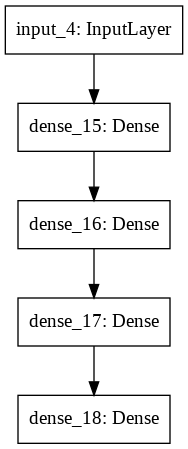

In [ ]:
tf.keras.utils.plot_model(sample_model.functional(), to_file="model.png")

## Defining losses and optimizers

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
optim = tf.keras.optimizers.Adam(1e-3)

In [ ]:
model = DNNModel(
    len(FEATURE_CLASSES), len(LABEL_CLASSES)
)
model.compile(optimizer = optim, loss = mae)

## Defining training checkpoints

In [ ]:
checkpoint_dir = './ProjectECO_Beta_Checkpoints/'

if not os.path.exists(checkpoint_dir):
  os.mkdir(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only = True)

## TRAINING!!

In [ ]:
model.fit(train_dataset.repeat(), callbacks=[checkpoint_callback],
          steps_per_epoch = 1000, epochs = 10)

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0954
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0231
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0171
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0149
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0128
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0122
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0115
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0108
Epoch 10/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0104


In [ ]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 82ms/step - loss: 0.2566


0.25659307837486267

In [ ]:
model.save_weights('beta_weights.h5')
model.functional().save('beta_model_func.h5')

In [ ]:
from google.colab import files

for name in os.listdir('./'):
  if not os.path.isdir(name):
    files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Standalone Prediction

In [2]:
!pip install tabulate
!curl -o label_classes.py https://raw.githubusercontent.com/Harrow-Enigma/TeamEngima-ProjectEco-AI/main/label_classes.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1802  100  1802    0     0  10238      0 --:--:-- --:--:-- --:--:-- 10180


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from label_classes import Label, FloatLabel, IntClass, IntClassMap

from datetime import timedelta, timezone
from datetime import datetime as dt
from tabulate import tabulate
from tqdm import tqdm
import pickle as pkl
import requests
import json
import os

### Pre-Requisite Objects

In [4]:
def standardize_on_params(arr, m, s):
  return (arr - m)/s

def destandardize(arr, m, s):
  return arr * s + m

def rescale_on_params(arr, arr_ofst, arr_range):
  return (arr - arr_ofst) / arr_range

def descale(arr, arr_ofst, arr_range):
  return arr * arr_range + arr_ofst

def normalize_on_params(arr, m, s, o, r):
  arr_std = standardize_on_params(arr, m, s)
  arr_norm = rescale_on_params(arr_std, o, r)
  return arr_norm

def denormalize(arr, m, s, o, r):
  return destandardize(descale(arr, o, r), m, s)

In [5]:
obj = pkl.load(open('beta_data_aux.data', 'rb'))

In [6]:
FEATURE_CLASSES = obj['features']['classes']
features_mean = obj['features']['mean']
features_stddv = obj['features']['std_dev']
features_ofst = obj['features']['offset']
features_range = obj['features']['range']

LABEL_CLASSES = obj['labels']['classes']
labels_mean = obj['labels']['mean']
labels_stddv = obj['labels']['std_dev']
labels_ofst = obj['labels']['offset']
labels_range = obj['labels']['range']

In [7]:
model = tf.keras.models.load_model('beta_model_func.h5')

### Pre-Requisite Data

In [8]:
def str2date(s):
  return dt.strptime(s, '%Y-%m-%dT%H:%M:%S.%f%z')

def dict2date(data_dict):
  return str2date(data_dict['DATE'])

def handle_exception(feat_class, timestep_data):
  try:
    _val = timestep_data[feat_class.key]
    if _val is not None:
      return feat_class.fwd_call(_val)
    return feat_class.fallback
  except:
    return feat_class.fallback

beta_api_url = 'https://dev-test.projecteco.ml/api/v1/rest/output/forms/'
response = requests.get(beta_api_url)
json_data = response.json()
json_data = sorted(json_data, key = dict2date)

for k in range(len(json_data)):
  try:
    _ = json_data[k]['localpollutiondata']
    _has_key = True
  except:
    print('Error: No `localpollutiondata` key')
    _has_key = False
  
  if _has_key:
    for pol_key in list(json_data[k]['localpollutiondata']\
                        ['data'].keys()):
      json_data[k][pol_key] = json_data[k]['localpollutiondata']\
                                       ['data'][pol_key]['v']
    json_data[k].pop('localpollutiondata')
  
server_features = []
server_labels = []

for t in json_data:
  server_features.append([handle_exception(c, t)
                          for c in FEATURE_CLASSES])
  server_labels.append([handle_exception(c, t)
                        for c in LABEL_CLASSES])

server_features = np.array(server_features, np.float32)
server_labels = np.array(server_labels, np.float32)

### Visualization Code

In [9]:
def visualize_inputs(inps, headers=('Input name', 'Input value')):
  data_arr = [[c.name, c.fwd_call(val)] for c, val in zip(FEATURE_CLASSES, inps)]
  print(tabulate(data_arr, headers=headers))

def visualize_features(feat, headers=('Feature name', 'Feature value')):
  data_arr = [[c.name, val] for c, val in zip(FEATURE_CLASSES, feat)]
  print(tabulate(data_arr, headers=headers))

def visualize_preds(preds, headers=('Prediction name', 'Prediction value')):
  data_arr = [[c.name, c.rev_call(val)] for c, val in zip(LABEL_CLASSES, preds)]
  print(tabulate(data_arr, headers))

In [10]:
def preproc(inps):
  feats = np.array([[c.fwd_call(val) for c, val in zip(FEATURE_CLASSES, entry)]
                   for entry in inps])
  feats_norm = normalize_on_params(feats, features_mean, features_stddv, 
                                   features_ofst, features_range)
  return feats_norm

def denorm_preds(preds_norm):
  return denormalize(preds_norm, labels_mean, labels_stddv,
                     labels_ofst, labels_range)

def visualize(inps, see_feats=False):
  feats_norm = preproc(inps)
  preds_norm = model.predict(feats_norm)
  preds = denormalize(preds_norm, labels_mean, labels_stddv,
                      labels_ofst, labels_range)
  
  for e, (i, f, p) in enumerate(zip(inps, feats_norm, preds)):
    print('Visualizing input {}'.format(e))
    print()
    visualize_inputs(i)
    print()
    if see_feats:
      visualize_features(f)
      print()
    visualize_preds(p)
    print('\n=====================================================================\n\n')

def compare_vis(inps, labs, see_feats=False):
  feats_norm = preproc(inps)
  preds_norm = model.predict(feats_norm)
  preds = denorm_preds(preds_norm)
  
  for e, (i, f, p, g) in enumerate(zip(inps, feats_norm, preds, labs)):
    print('Visualizing input {}'.format(e))
    print()
    visualize_inputs(i)
    print()
    if see_feats:
      visualize_features(f)
      print()
    visualize_preds(p, headers=("Prediction Name", "Model Output"))
    print()
    visualize_preds(g, headers=("Prediction Name", "Ground Truth"))
    print('\n==================================================================\n\n')

In [11]:
def locate_label_by_name(_name, classes):
  for e, i in enumerate(classes):
    if i.name == _name:
      return e

def replace_in_arr(arr, idx, newval):
  ret = arr.copy()
  ret[idx] = newval
  return ret

def makegraph(x, y, xlab='', ylab='', title=''):
  plt.figure(figsize=(8, 5), dpi=150)
  plt.plot(x, y)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.title(title)
  plt.show()

def autorange(featurename, sub_d=100):
  feats = server_features[:, locate_label_by_name(featurename,
                                                  FEATURE_CLASSES)]
  step = (feats.max() - feats.min()) / (sub_d - 1)
  return np.arange(feats.min(), feats.max() + step, step)

def plot_relation_by_name(featurename,
                          labelname,
                          _range,
                          _vars=server_features[0]):
  _vars = server_features[0]
  _feat_loc = locate_label_by_name(featurename, FEATURE_CLASSES)
  _lab_loc = locate_label_by_name(labelname, LABEL_CLASSES)

  _x = [replace_in_arr(_vars, _feat_loc, i) for i in _range]
  _y = denorm_preds(model.predict(preproc(_x)))[:, _lab_loc]

  makegraph(_range, _y, featurename, labelname,
            'How {} responses vary with {} levels'.format(labelname,
                                                          featurename))

def plot_relation_from_data(featurename,
                            labelname):
  _x = server_features[:, locate_label_by_name(featurename, FEATURE_CLASSES)]
  _y = server_labels[:, locate_label_by_name(labelname, LABEL_CLASSES)]

  _idx = np.argsort(_x)
  _x = _x[_idx]
  _y = _y[_idx]

  makegraph(_x, _y, featurename, labelname,
            'How {} responses vary with {} levels'.format(labelname,
                                                          featurename))

### Visualization

In [12]:
visualize(server_features)

Visualizing input 0

Input name      Input value
------------  -------------
h                      77.5
no2                    34.3
o3                     15.8
p                     997.1
pm10                   35
pm25                   79
t                      31.6
w                       1.5
wg                      6

Prediction name                                 Prediction value
----------------------------------------------  ------------------
Q1 (General feeling)                            2
Q2 (Concentration)                              4
Q3 (Work Stress)                                4
Q4 (Dizziness, headaches, shortness of breath)  no
Q5 (Allergic responses)                         no



Visualizing input 1

Input name      Input value
------------  -------------
h                      87
no2                    22
o3                      2
p                    1015
pm10                   10
pm25                   13
t                      14
w                       1.5
wg

In [13]:
compare_vis(server_features, server_labels)

Visualizing input 0

Input name      Input value
------------  -------------
h                      77.5
no2                    34.3
o3                     15.8
p                     997.1
pm10                   35
pm25                   79
t                      31.6
w                       1.5
wg                      6

Prediction Name                                 Model Output
----------------------------------------------  --------------
Q1 (General feeling)                            2
Q2 (Concentration)                              4
Q3 (Work Stress)                                4
Q4 (Dizziness, headaches, shortness of breath)  no
Q5 (Allergic responses)                         no

Prediction Name                                 Ground Truth
----------------------------------------------  --------------
Q1 (General feeling)                            2
Q2 (Concentration)                              4
Q3 (Work Stress)                                4
Q4 (Dizziness, headaches,

In [14]:
server_features[:, locate_label_by_name('pm10', FEATURE_CLASSES)]

array([35., 10., 10., 18.,  9., 38.,  8.,  0., 10.,  9., 14., 19.,  7.,
       10., 11., 30., 39., 28., 10., 46.], dtype=float32)

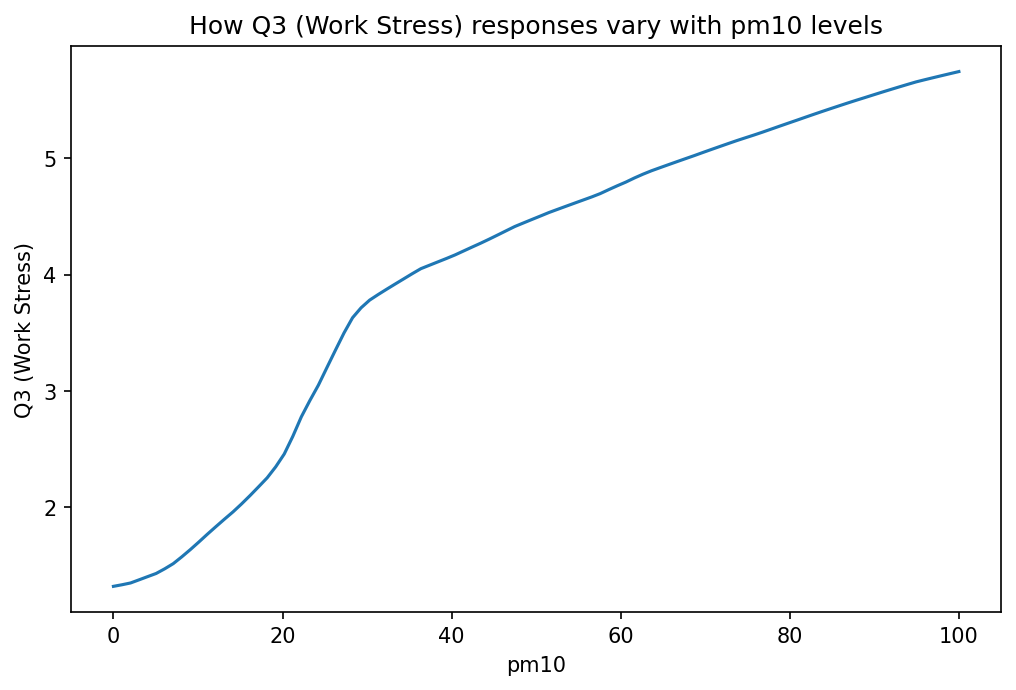

In [16]:
# How stress levels vary with PM2.5 concentration,
# assuming that all other values follow server_features[0]
plot_relation_by_name('pm10', 'Q3 (Work Stress)',
                      autorange('pm25', 100))

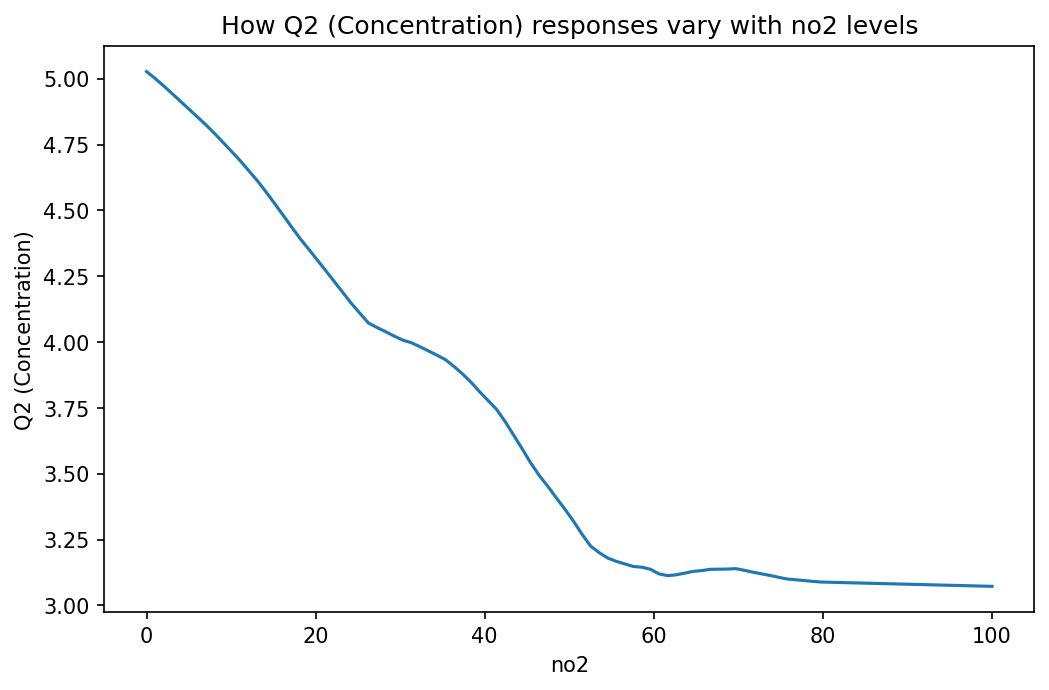

In [17]:
plot_relation_by_name('no2', 'Q2 (Concentration)',
                      autorange('pm25', 100))

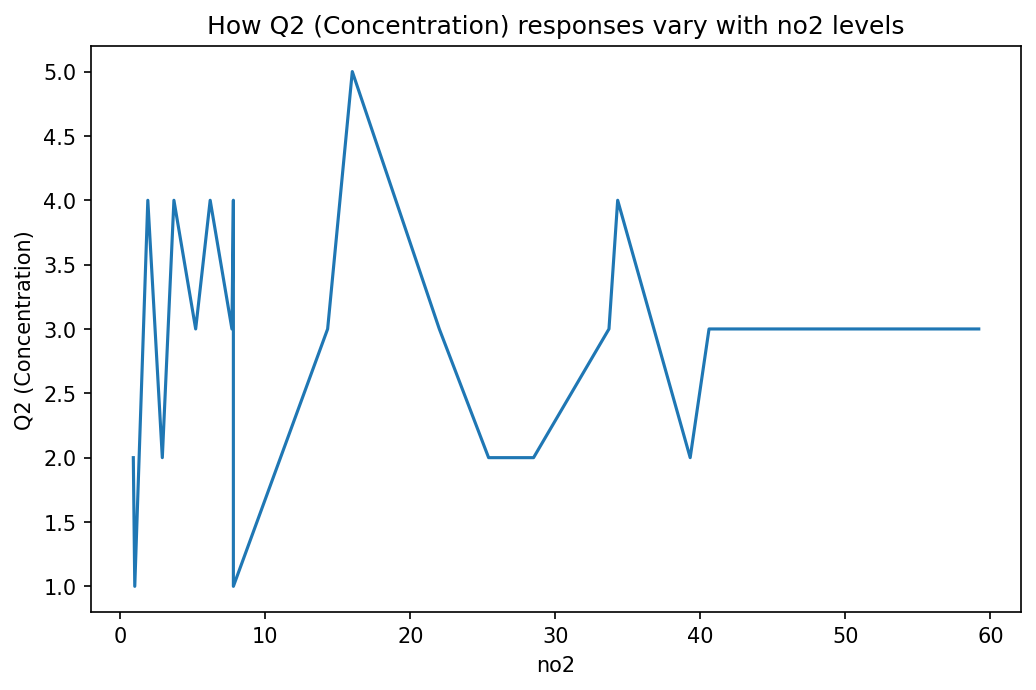

In [18]:
plot_relation_from_data('no2', 'Q2 (Concentration)')